# Алгоритм Ремеза

Библиотеки:

In [1]:
import numpy as np
from scipy import linalg as LA
import math
import matplotlib.pyplot as plt

from scipy import optimize as opt

import warnings
warnings.filterwarnings("ignore")

Функция для оценки $C[a,b]$-нормы ошибки:

In [2]:
def estimate_normC(f, poly, a, b):
    # f -  функция, poly - многочлен для приближения
    # a, b - концы отрезка
    
    c_norm = 0
    nodes = np.linspace(a, b, 10000)
    for node in nodes:
        current_err = abs(f(node) - poly(node))
        if (current_err > c_norm):
            c_norm = current_err
    
    return c_norm

In [3]:
def func_c_norm(f, a, b):
    # приближенная C-норма функции на отрезке
    xes = np.linspace(a, b, 100000)
    norm = 0
    for x in xes:
        if (abs(f(x)) > norm):
            norm = abs(f(x))
            
    return norm

In [4]:
def check_alternance(points, f, f_signed, a, b):
    # Фунция возвращает, выполнено ли условие альтернанса для точек points и функции f на отрезке [a, b]
    
    is_alternance = True
    
    for i in range(len(points) - 1):
        if (f_signed(points[i]) * f_signed(points[i+1]) > 0):
            is_alternance = False
    
    f_norm = func_c_norm(f, a, b)
    
    for i in range(len(points)):
        # this is practically ||f|| != |f(x_i)|
        if (abs(abs(f_signed(points[i])) - f_norm) >= 1e-2):
            is_alternance = False
        #print('point norm = ', abs(f(points[i])))
    
    #print('f_norm = ', f_norm)
            
    return is_alternance

In [5]:
def apply_newton(f, x0, eps_for_x):
    # функция говорит, можем ли применить метод Ньютона в данной точке (для поиска корня)
    
    if (f(x0) <= eps_for_x):
        return True
    else:
        return False

    
def add_solution_to_list(solutions, new_sol, eps_sol):
    # функция говорит, является ли решение новым или уже было найдено ранее

    is_new_sol = True
    solutions = np.array(solutions)
    if (solutions.shape[0] > 0):
        for sol in solutions:
            if (abs(sol - new_sol) < eps_sol):
                is_new_sol = False
    
    return is_new_sol


def find_N_roots(f, a, b, N):
    #точность, с которой ищем корни
    #Считаем, что отрезок адекватный: не размера 1e-10 и т.п.
    eps = (b - a) * 1e-10
    
    # это, грубо говоря, погрешность. Если разница между решениями меньше нее, то считаем их равными
    eps_sol = eps * 10
    
    # в будущем будет n+1 решение
    solutions = []
    
    start_points = np.linspace(a, b, N * 1000)   
    for x0 in start_points:
        #print(x0)
        if (apply_newton(f, x0, 1e-1)):
            new_sol = opt.newton(f, x0, tol = eps, maxiter = 10000)
            if (add_solution_to_list(solutions, new_sol, eps_sol) and (a <= new_sol) and (b >= new_sol)):
                solutions.append(new_sol)
                #print(new_sol)
           
    solutions = np.array(solutions)
    assert solutions.shape[0] == N+1
    return solutions


In [6]:
# ищет точку с наибольшим по модулю значением функции на отрезке
def max_on_interval(f, a, b):
    #сетка
    xes = np.linspace(a, b, 1000000)
    
    max_x = 0
    
    for x in xes:
        if abs(f(x)) > abs(f(max_x)):
            max_x = x    
    
    #print(max_x)
    #x_resulting = opt.newton(f, max_x, tol = 1e-12)
    return max_x


def max_on_each_intervals(f, a, b, solutions):
    # Ищем максимум модуля функции на каждом отрезке с концами a - solutions - b -> дает n+2 точек
    
    solutions = np.array(solutions)
    new_points = []
    new_points.append(max_on_interval(f, a, solutions[0]))
    for i in range(solutions.shape[0] - 1):
         new_points.append(max_on_interval(f, solutions[i], solutions[i + 1]))
    new_points.append(max_on_interval(f, solutions[-1], b))
    
    return new_points

In [7]:
def find_new_points(f, a, b, n):
    # Замена точек в алгоритме Ремеза
    
    solutions = find_N_roots(f, a, b, n)
    new_points = max_on_each_intervals(f, a, b, solutions)
    return new_points

In [8]:
def remez_algo(xes, f, a, b, n):
    # 1 шаг алгоритма: матрица системы
    A = np.zeros((n+2, n+2))
    xes = np.array(xes)
    #print(xes)
    
    for i in range(n+1):
        for j in range(n+2):
            A[i][j] = (xes[j]) ** i
    
    for i in range(n+2):
        A[n+1][i] = (-1) ** (i+1)
    
    A = np.transpose(A)
        
    # правая часть
    b_col = f(xes)
    b_col = np.transpose(b_col)
    
    # решение системы
    solution = np.linalg.solve(A, b_col)
    ces = solution[0:n+1]
    E = solution[n+1]
    
    def p_n(x):
        res = 0
        for i in range (n+1):
            res += ces[i] * (x ** i)
        return res
    
    def err_func(x):
        return abs(f(x) - p_n(x))
    
    def err_func_signed(x):
        return f(x) - p_n(x)
    
    # шаг 2
    if not (check_alternance(xes, err_func, err_func_signed, a, b)):
        # заменяем часть точек и переходим к шагу 1
        m_points = find_new_points(err_func, a, b, n)
        return remez_algo(m_points, f, a, b, n)
    
    else:
        return ces

In [9]:
def remez(f, a, b, n):
    # f = function
    # a, b = left and right points of the segment
    # n = degree of the polynomial
    
    # норма ошибки, посчитаем позже, пока просто определим ее
    eps = 0
    
    points = np.linspace(a, b, n+2)
    
    # коэффициенты многочлена
    coefs = remez_algo(points, f, a, b, n)
    
    def poly(x):
        res = 0
        for i in range(len(coefs)):
            res += coefs[i] * (x ** i)
        return res
    
    eps = estimate_normC(f, poly, a, b)
    
    return coefs, eps 

### Тестовая функция 1

Рассмотрим функцию $e^x$, которую мы будем приближать на отрезке $[-\pi, \pi]$ многочленом $4$-й степени.

In [10]:
def func_1(x):
    return np.exp(x)

In [11]:
poly_4, eps4 = remez(func_1, -np.pi, np.pi, 4)

In [12]:
def concstruct_func(cofs, x):
    res = 0
    cofs = np.array(cofs)
    for i in range(cofs.shape[0]):
        res += cofs[i] * (x ** i)
    return res

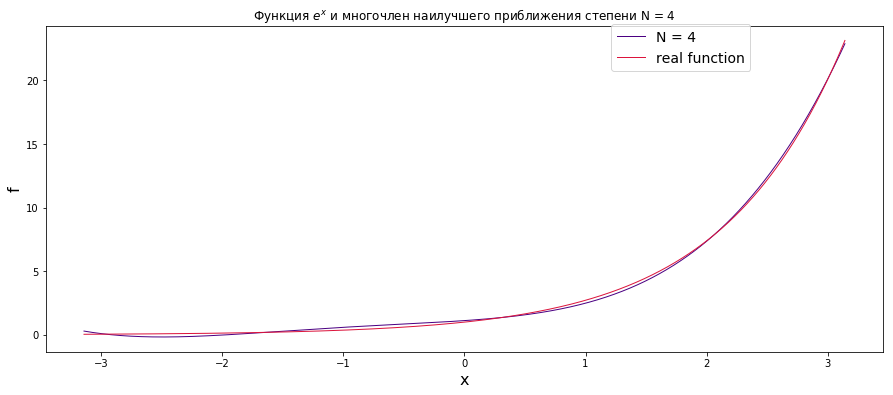

In [13]:
grid = np.linspace(-np.pi, np.pi, 10000)
plt.figure(figsize=(15, 6))
plt.plot(grid, concstruct_func(poly_4, grid), color = 'indigo', label = "N = 4", linewidth = 1)
plt.plot(grid, func_1(grid), color = 'crimson', label = "real function", linewidth = 1)
plt.xlabel('x', fontsize=16)
plt.ylabel('f', fontsize=16)
plt.legend(fontsize = 14, bbox_to_anchor=(0.85,1.025))
plt.title("Функция $e^x$ и многочлен наилучшего приближения степени N = 4")
plt.show()

По графику можно заметить, что приближение довольно хорошее.

Построим теперь график ошибки для нашего многочлена наилучшего приближения. Я снова возьму N = 4.

In [14]:
rem_coef_4 = remez(func_1, -np.pi, np.pi, 4)[0]

In [15]:
from scipy.interpolate import BarycentricInterpolator

In [16]:
xes = []

# Ln - хотим степени 4 -> берем 5 точек
for k in range(1, 5+1):
    a = -np.pi
    b = np.pi
    xes.append((a + b)/2 + 0.5 * (b - a) * np.cos((2 * k - 1) / (2 * 5) * np.pi))
    
xes = np.array(xes)

In [17]:
# узлы Чебышева
xes

array([ 2.98783216e+00,  1.84658183e+00,  1.92367069e-16, -1.84658183e+00,
       -2.98783216e+00])

In [18]:
interp = BarycentricInterpolator(xes, func_1(xes))

In [19]:
f_xes = func_1(xes)

In [20]:
# для Лагранжа
n = 5

def find_I(j, xx):
    res = 1
    for i in range(n):
        if(i != j):
            res *= (xx - xes[i])
    for i in range(n):
        if(i != j and xes[j] != xes[i]):
            res /= (xes[j] - xes[i])
    return res

In [21]:
def lagran(x, m):
    res = 0
    for i in range(m):
        res = res + f_xes[i] * find_I(i, x)
    return res

In [22]:
lagr_interp = lagran(grid, 4)

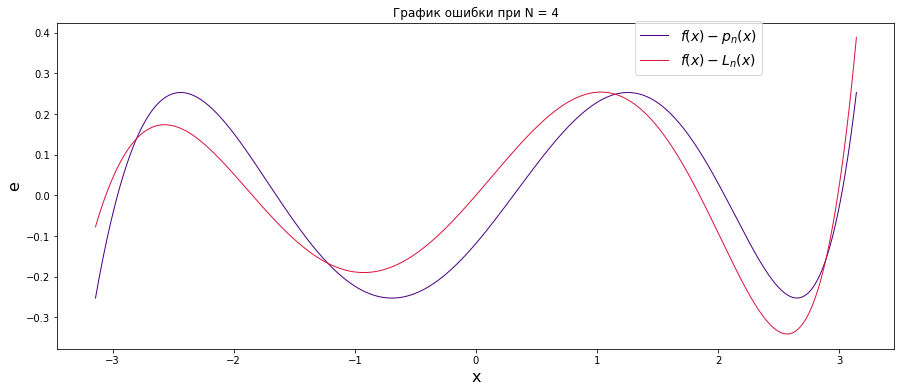

In [23]:
grid = np.linspace(-np.pi, np.pi, 10000)
plt.figure(figsize=(15, 6))
plt.plot(grid, func_1(grid) - concstruct_func(rem_coef_4, grid) , color = 'indigo', label = "$f(x) - p_n(x)$", linewidth = 1)
plt.plot(grid, func_1(grid) - lagr_interp, color = 'crimson', label = "$f(x) - L_n(x)$", linewidth = 1)
plt.xlabel('x', fontsize=16)
plt.ylabel('e', fontsize=16)
plt.legend(fontsize = 14, bbox_to_anchor=(0.85,1.025))
plt.title("График ошибки при N = 4")
plt.show()

Как мы видим, в целом, оба алгоритма (при помощи полинома Лагранжа и при помощи Алгоритма Ремеза) дают похожие результаты. Кое-где лучше Лагранж, в других случаях - Ремез.

Убедимся, что наш алгоритм работает правильно: ошибка должна иметь n+2 точки альтернанса. Вообще у нас это проверяется в самом алгоритме, но посмотрим это и для нашей конкретной реализации.

Выведем отдельно еще раз только наш график ошибки.

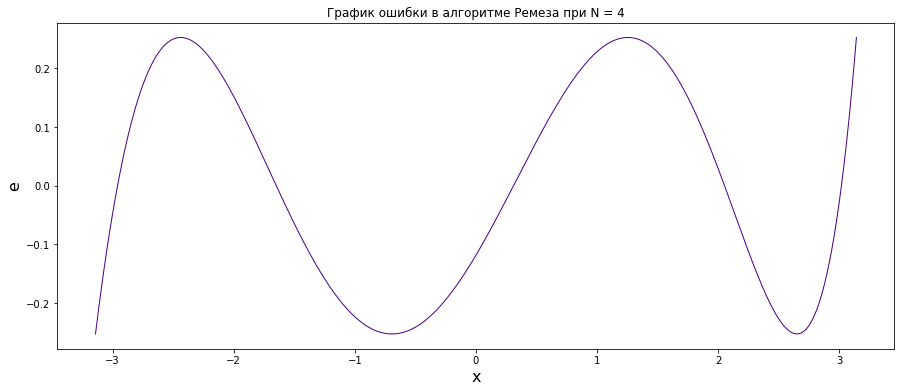

In [24]:
grid = np.linspace(-np.pi, np.pi, 10000)
plt.figure(figsize=(15, 6))
plt.plot(grid, func_1(grid) - concstruct_func(rem_coef_4, grid) , color = 'indigo', linewidth = 1)
plt.xlabel('x', fontsize=16)
plt.ylabel('e', fontsize=16)
plt.title("График ошибки в алгоритме Ремеза при N = 4")
plt.show()

In [25]:
# функция ошибки
def err_4(x):
    return func_1(x) - concstruct_func(rem_coef_4, x)

In [26]:
def abs_err_4(x):
    return abs(func_1(x) - concstruct_func(rem_coef_4, x))

In [27]:
def check_f_alternance(points, f, a, b):
    # Фунция возвращает, выполнено ли условие альтернанса для точек points и функции f на отрезке [a, b]
    
    is_alternance = True
    
    for i in range(len(points) - 1):
        if (f(points[i]) * f(points[i+1]) > 0):
            is_alternance = False
    
    f_norm = func_c_norm(f, a, b)
    
    for i in range(len(points)):
        if (abs(abs(f(points[i])) - f_norm) >= 1e-2):
            is_alternance = False
                
    return is_alternance

In [28]:
n = 4 
err_roots = find_N_roots(abs_err_4, -np.pi, np.pi, 4)

In [29]:
err_maxes = max_on_each_intervals(abs_err_4, -np.pi, np.pi, err_roots)

In [30]:
print(err_maxes)

[-3.141592653589793, -2.4384558999327637, -0.6938613636622195, 1.2538969216290856, 2.650634205229629, 3.141592653589793]


Как можно заметить, указанные выше точки совпадают с теми, что дают наибольшую ошибку и по графику.

In [31]:
if (check_f_alternance(err_maxes, err_4, -np.pi, np.pi)):
    print('There is alternance!')
else:
    print('No alternance, something went wrong')

There is alternance!


Итак, условие альтернанса действительно выполнено, у нас 4+2=6 точек альтернанса!

### Тестовая функция 2

Будем использовать N=4, и функцию берем посложнее: $x \cdot e^x$

In [32]:
def func_2(x):
    return x * np.exp(x)

In [33]:
poly_6, eps6 = remez(func_2, -np.pi, np.pi, 4)

In [34]:
poly_6

array([ 0.79395875, -0.96614847,  0.00723594,  1.22429331,  0.36358064])

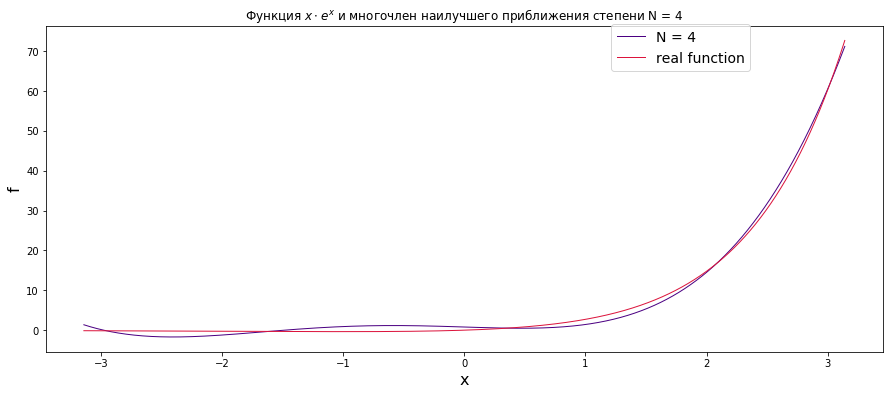

In [35]:
grid = np.linspace(-np.pi, np.pi, 10000)
plt.figure(figsize=(15, 6))
plt.plot(grid, concstruct_func(poly_6, grid), color = 'indigo', label = "N = 4", linewidth = 1)
plt.plot(grid, func_2(grid), color = 'crimson', label = "real function", linewidth = 1)
plt.xlabel('x', fontsize=16)
plt.ylabel('f', fontsize=16)
plt.legend(fontsize = 14, bbox_to_anchor=(0.85,1.025))
plt.title("Функция $x \cdot e^x$ и многочлен наилучшего приближения степени N = 4")
plt.show()

In [36]:
xes2 = []

# Ln - хотим степени 4 -> берем 5 точек
for k in range(1, 5+1):
    a = -np.pi
    b = np.pi
    xes2.append((a + b)/2 + 0.5 * (b - a) * np.cos((2 * k - 1) / (2 * 5) * np.pi))
    
xes2 = np.array(xes2)

fxes2 = func_2(xes2)

In [37]:
# для Лагранжа
n = 5

def find_I(j, xx):
    res = 1
    for i in range(n):
        if(i != j):
            res *= (xx - xes2[i])
    for i in range(n):
        if(i != j and xes2[j] != xes2[i]):
            res /= (xes2[j] - xes2[i])
    return res

In [38]:
def lagran(x, m):
    res = 0
    for i in range(m):
        res = res + fxes2[i] * find_I(i, x)
    return res

In [39]:
lagr_interp = lagran(grid, 4)

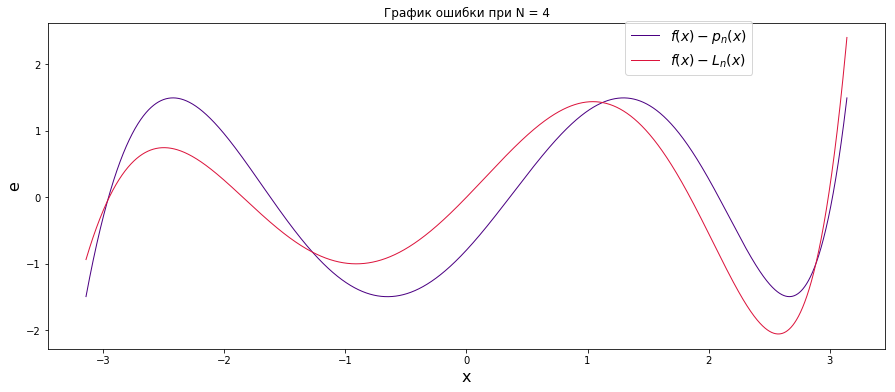

In [40]:
grid = np.linspace(-np.pi, np.pi, 10000)
plt.figure(figsize=(15, 6))
plt.plot(grid, func_2(grid) - concstruct_func(poly_6, grid) , color = 'indigo', label = "$f(x) - p_n(x)$", linewidth = 1)
plt.plot(grid, func_2(grid) - lagr_interp, color = 'crimson', label = "$f(x) - L_n(x)$", linewidth = 1)
plt.xlabel('x', fontsize=16)
plt.ylabel('e', fontsize=16)
plt.legend(fontsize = 14, bbox_to_anchor=(0.85,1.025))
plt.title("График ошибки при N = 4")
plt.show()

Здесь можно заметить, что алгоритм Ремеза работает по точности почти так же, как приближение за счет полиномов Лагранжа.



Убедимся, что наш алгоритм работает правильно: ошибка должна иметь n+2 точки альтернанса. Вообще у нас это проверяется в самом алгоритме, но посмотрим это и для нашей конкретной реализации.

Выведем отдельно еще раз только наш график ошибки.

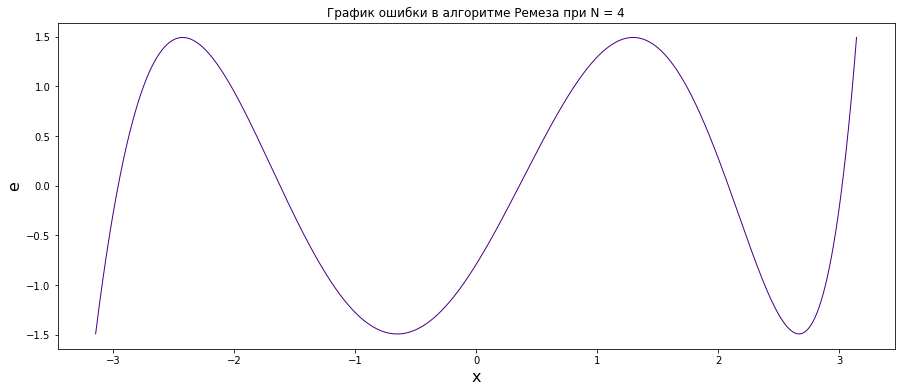

In [41]:
grid = np.linspace(-np.pi, np.pi, 10000)
plt.figure(figsize=(15, 6))
plt.plot(grid, func_2(grid) - concstruct_func(poly_6, grid) , color = 'indigo', linewidth = 1)
plt.xlabel('x', fontsize=16)
plt.ylabel('e', fontsize=16)
plt.title("График ошибки в алгоритме Ремеза при N = 4")
plt.show()

In [42]:
# функция ошибки
def err_6(x):
    return func_2(x) - concstruct_func(poly_6, x)

def abs_err_6(x):
    return abs(func_2(x) - concstruct_func(poly_6, x))

In [43]:
n = 4 
err_roots = find_N_roots(abs_err_6, -np.pi, np.pi, 4)

In [44]:
err_maxes = max_on_each_intervals(abs_err_6, -np.pi, np.pi, err_roots)

In [45]:
print(err_maxes)

[-3.141592653589793, -2.423005844492586, -0.6516210279714835, 1.2967677452900594, 2.666582043406094, 3.141592653589793]


Как можно заметить, указанные выше точки совпадают с теми, что дают наибольшую ошибку и по графику.

In [46]:
if (check_f_alternance(err_maxes, err_6, -np.pi, np.pi)):
    print('There is alternance!')
else:
    print('No alternance, something went wrong')

There is alternance!


Итак, условие альтернанса действительно выполнено, у нас 4+2=6 точек альтернанса!